# Lung Cancer Classifier

## Description

### Dataset
`https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images`

### Objective

`Make a Lung Cancer Cells Classification using Convolutional Neural Networks.`

### Problem Statement

`1. How much data is required to train the model ?`<br>
`2. What models are used ?`<br>
`3. How is the model performance ?`<br>
`4. What kind of data that suitable for the model ?`<br>
`5. How to improve the model ?`

## Working Area
### 1. Import Libraries

In [1]:
# Import basic libraries
import os
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Train Test Split
from sklearn.model_selection import train_test_split

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Temporary Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Import model
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

# Model Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 2. Data Loading

In [2]:
# Load dataset from directory
lung_direct = '..\LungCancerClassifier\lung_colon_image_set\lung_image_sets'
lung_set = os.listdir(lung_direct)

# Brief check
lung_set

['lung_aca', 'lung_n', 'lung_scc']

Description :<br>
lung_aca = Lung Adenocarcinoma<br>
lung_n = Lung Benign Tissue<br>
lung_scc = Lung Squamous Cell Carcinoma

In [3]:
# Directories for each class
lung_aca_dir = os.path.join(lung_direct, 'lung_aca')
lung_n_dir = os.path.join(lung_direct, 'lung_n')
lung_scc_dir = os.path.join(lung_direct, 'lung_scc')

# List of directories
aca_all = glob.glob(lung_aca_dir + "/*.jpeg")
n_all = glob.glob(lung_n_dir + "/*.jpeg")
scc_all = glob.glob(lung_scc_dir + "/*.jpeg")

all_dir = aca_all + n_all + scc_all # List of all data

In [4]:
# Create function to make dataframe using directory list
def create_dataframe_from_list(list):
    data = {}
    label = {}
    for i in range(0, len(list)):
        data[i] = list[i]
        label[i] = list[i].split('\\')[-2] # Their folder will be the label
    data = data.values()
    label = label.values()
    return pd.DataFrame({'data' : data, 'label' : label})

df = create_dataframe_from_list(all_dir) # Create dataframe from list
df = df.sample(frac = 1) # Random the dataframe rows order
df.head(5)

data     label
10926  ..\LungCancerClassifier\lung_colon_image_set\l...  lung_scc
8639   ..\LungCancerClassifier\lung_colon_image_set\l...    lung_n
11169  ..\LungCancerClassifier\lung_colon_image_set\l...  lung_scc
9759   ..\LungCancerClassifier\lung_colon_image_set\l...    lung_n
7842   ..\LungCancerClassifier\lung_colon_image_set\l...    lung_n

### 3. Exploratory Data Analysis (EDA)

In [55]:
# Make function for generate random numbers
def RNG(num_j):
    j = {}
    for i in range(num_j):
        j[i] = random.randint(1,len(os.listdir(lung_direct + '/' + lung)))
    j = list(j.values())
    return j

In [57]:
# Number of images for each disease
num_train = {}
num_val = {}
for lung in lung_set:
    num_train[lung] = len(os.listdir(lung_direct + '/' + lung))
img_per_class = pd.DataFrame(num_train.values(), index=num_train.keys(), columns=["images"])
print('Data Distribution :')
img_per_class

Data Distribution :


images
lung_aca    5000
lung_n      5000
lung_scc    5000

Statement :<br>
Each class has the same amount of data.

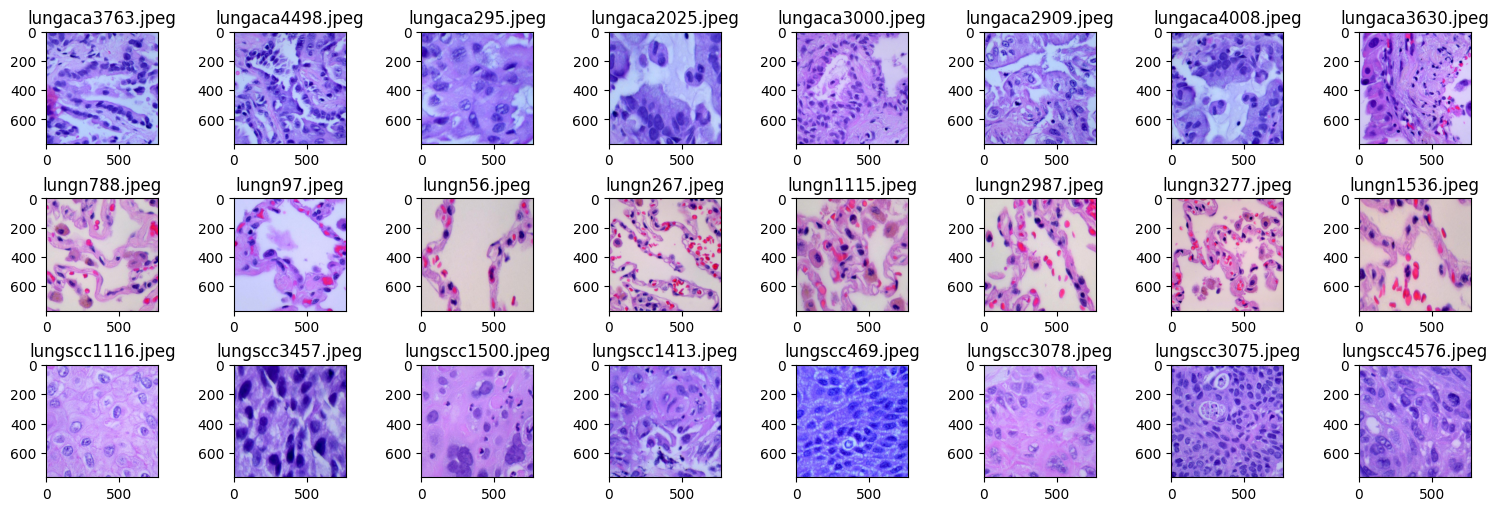

In [59]:
# Create a random number for sampling
samp_num = 8
lung_aca_RNG, lung_n_RNG, lung_scc_RNG = RNG(samp_num), RNG(samp_num), RNG(samp_num)

# Make list directories for each cancer class
lung_aca_RNG_dir = {} # Lung Adenocarcinoma
for i in range(0,len(lung_aca_RNG)):
    lung_aca_RNG_dir[i] = '/lung_aca/lungaca{}.jpeg'.format(lung_aca_RNG[i])
lung_aca_RNG_dir = list(lung_aca_RNG_dir.values())

lung_n_RNG_dir = {} # Lung Benign Tissue
for i in range(0,len(lung_n_RNG)):
    lung_n_RNG_dir[i] = '/lung_n/lungn{}.jpeg'.format(lung_n_RNG[i])
lung_n_RNG_dir = list(lung_n_RNG_dir.values())

lung_scc_RNG_dir = {} # Lung Benign Tissue
for i in range(0,len(lung_scc_RNG)):
    lung_scc_RNG_dir[i] = '/lung_scc/lungscc{}.jpeg'.format(lung_scc_RNG[i])
lung_scc_RNG_dir = list(lung_scc_RNG_dir.values())

# Image sampling plot
fig, axs = plt.subplots(3,samp_num, layout="constrained", figsize=(15,5))
for i in range(0,samp_num):
    
    # Lung Adenocarcinoma
    axs[0,i].imshow(Image.open(lung_direct + lung_aca_RNG_dir[i]))
    axs[0,i].set_title('lungaca{}.jpeg'.format(lung_aca_RNG[i]))

    # Lung Benign Tissue
    axs[1,i].imshow(Image.open(lung_direct + lung_n_RNG_dir[i]))
    axs[1,i].set_title('lungn{}.jpeg'.format(lung_n_RNG[i]))

    # Lung Squamous Cell Carcinoma
    axs[2,i].imshow(Image.open(lung_direct + lung_scc_RNG_dir[i]))
    axs[2,i].set_title('lungscc{}.jpeg'.format(lung_scc_RNG[i]))

In [23]:
# Define a function to calculate the total number of Red, Green, and Blue
def RGB_single(img):
    width, height = img.size
    r_total = 0
    g_total = 0
    b_total = 0
    count = 0
    for x in range(0, width):
        for y in range(0, height):
            r, g, b = img.getpixel((x, y))
            r_total += r
            g_total += g
            b_total += b
            count += 1
    return (r_total/count, g_total/count, b_total/count)

def RGB_counter(direct, RNG_direct):
    sum_red = 0
    sum_green = 0
    sum_blue = 0
    for i in range(0, len(lung_aca_RNG_dir)):
        red, green, blue = RGB_single(Image.open(direct + RNG_direct[i]))
        sum_red += red
        sum_green += green
        sum_blue += blue
    return sum_red, sum_green, sum_blue

def RGB_counter_2(RNG_direct):
    sum_red = 0
    sum_green = 0
    sum_blue = 0
    for i in range(0, len(RNG_direct)):
        red, green, blue = RGB_single(Image.open(RNG_direct[i]))
        sum_red += red
        sum_green += green
        sum_blue += blue
    return sum_red, sum_green, sum_blue

Note : Somehow, using triple 'for' function generate a longer computation performance.

Lung Adenocarcinoma
Red 8 samples   : 29.53 %
Green 8 samples : 25.16 %
Blue 8 samples  : 45.31 %


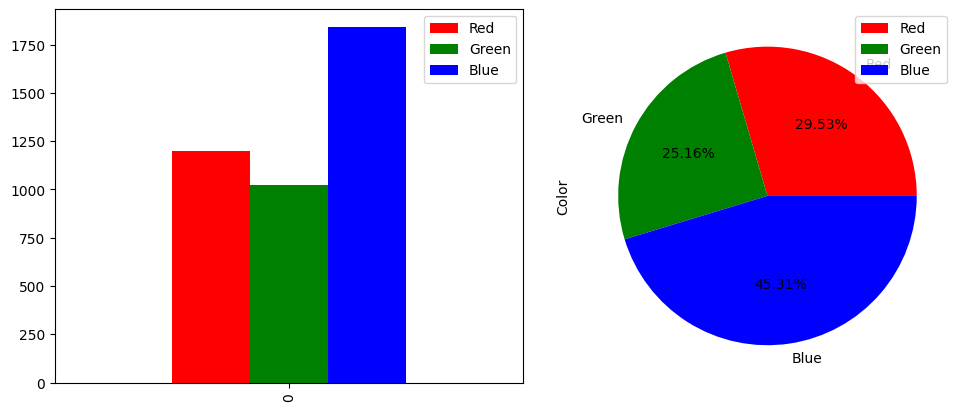

Lung Benign Tissue
Red 8 samples   : 35.61 %
Green 8 samples : 28.28 %
Blue 8 samples  : 36.11 %


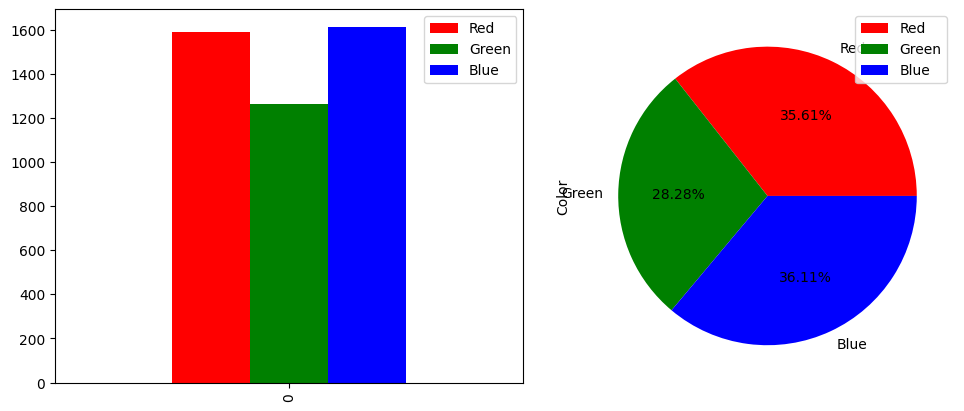

Lung Squamous Cell Carcinoma
Red 8 samples   : 30.77 %
Green 8 samples : 23.51 %
Blue 8 samples  : 45.72 %


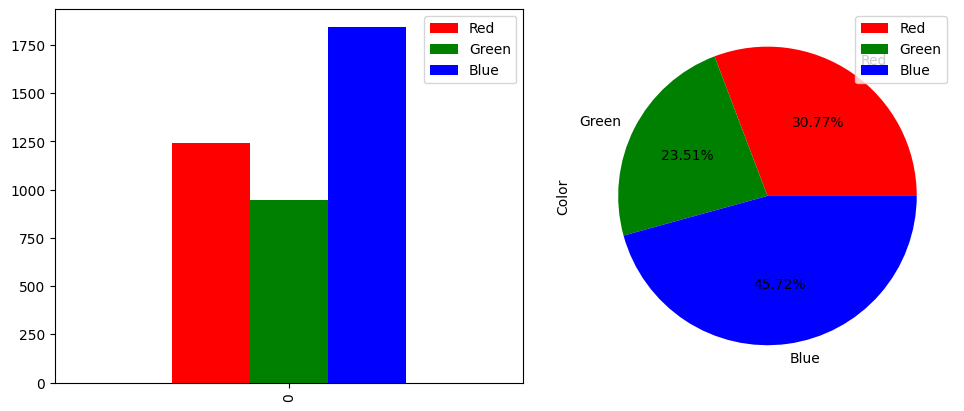

In [60]:
# Count RGB for each cancer class and plot colour composition

# Lung Adenocarcinoma
print('Lung Adenocarcinoma')

aca_R, aca_G, aca_B = RGB_counter(lung_direct, lung_aca_RNG_dir)
print('Red {} samples   :'.format(samp_num), round(aca_R/(aca_R + aca_G + aca_B) * 100, 2), '%')
print('Green {} samples :'.format(samp_num), round(aca_G/(aca_R + aca_G + aca_B) * 100, 2), '%')
print('Blue {} samples  :'.format(samp_num), round(aca_B/(aca_R + aca_G + aca_B) * 100, 2), '%')

aca_RGB_sum_df_01 = pd.DataFrame({'Red': [aca_R], 'Green': [aca_G], 'Blue': [aca_B]})
aca_RGB_sum_df_02 = pd.DataFrame({'Color': [aca_R, aca_G, aca_B]}, index = ['Red', 'Green', 'Blue'])

fig, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
aca_RGB_sum_df_01.plot.bar(color={'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[0])
aca_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[1])
plt.show()

# Lung Benign Tissue
print('Lung Benign Tissue')

n_R, n_G, n_B = RGB_counter(lung_direct, lung_n_RNG_dir)
print('Red {} samples   :'.format(samp_num), round(n_R/(n_R + n_G + n_B) * 100, 2), '%')
print('Green {} samples :'.format(samp_num), round(n_G/(n_R + n_G + n_B) * 100, 2), '%')
print('Blue {} samples  :'.format(samp_num), round(n_B/(n_R + n_G + n_B) * 100, 2), '%')

n_RGB_sum_df_01 = pd.DataFrame({'Red': [n_R], 'Green': [n_G], 'Blue': [n_B]})
n_RGB_sum_df_02 = pd.DataFrame({'Color': [n_R, n_G, n_B]}, index = ['Red', 'Green', 'Blue'])

fig, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
n_RGB_sum_df_01.plot.bar(color={'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[0])
n_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[1])
plt.show()

# Lung Squamous Cell Carcinoma
print('Lung Squamous Cell Carcinoma')
scc_R, scc_G, scc_B = RGB_counter(lung_direct, lung_scc_RNG_dir)
print('Red {} samples   :'.format(samp_num), round(scc_R/(scc_R + scc_G + scc_B) * 100, 2), '%')
print('Green {} samples :'.format(samp_num), round(scc_G/(scc_R + scc_G + scc_B) * 100, 2), '%')
print('Blue {} samples  :'.format(samp_num), round(scc_B/(scc_R + scc_G + scc_B) * 100, 2), '%')

scc_RGB_sum_df_01 = pd.DataFrame({'Red': [scc_R], 'Green': [scc_G], 'Blue': [scc_B]})
scc_RGB_sum_df_02 = pd.DataFrame({'Color': [scc_R, scc_G, scc_B]}, index = ['Red', 'Green', 'Blue'])

fig, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
scc_RGB_sum_df_01.plot.bar(color={'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[0])
scc_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[1])
plt.show()

Statement :<br>
Adenocarcinoma : Dominated by Blue<br>
Benign Tissue : Dominated by Red and Blue<br>
Squamous Cell Carcinoma : Dominated by Blue<br>
Since Adenocarcinoma and Squamous Cell Carcinoma have nearly the same colour compositions, manipulating the pattern for filtering might be giving better performance.

### 4. Data Preprocessing

In [5]:
# Splitting train validation and test set
train_val_set, test_set = train_test_split(df, test_size = 0.15, random_state = 1) # 15% of total data will be test set
train_set, val_set = train_test_split(train_val_set, test_size = 0.20, random_state = 2) # 20% of 85% total data will be test set

Statement :<br>
Final composition for every set coresponding to total data will be:<br>
15% of total dataset will be test set<br>
17% of total dataset will be validation set<br>
68% of total dataset will be train set

In [6]:
# Data augmentation

# Train set
train_gen = ImageDataGenerator(
    rescale = 1./255 # Pixel normalization
    ,rotation_range = 180 # No particular angle on cancer cells photos
    ,fill_mode = 'reflect' # To keep cancer cells remain cell-like
    ,zoom_range = 0.3 # There is no obvious magnification so that the cancer cells can be seen clearly
    ,horizontal_flip = True
    ,vertical_flip = True)

# Validation set
val_gen = ImageDataGenerator(
    rescale = 1./255)

# Test set
test_gen = ImageDataGenerator(
    rescale = 1./255)

Statement :<br>
Train : There's no particular angle, magnification, and brigtness level  to identify cancer cells.<br>
Validation : Only pixel scaling is needed.<br>
Test : Same as validation.<br>
Source : https://www.mdpi.com/2571-5577/5/5/87

In [7]:
# Generating dataset

# Train set
train_ds = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 'data',
    y_col = 'label',
    target_size = ( 225, 225 ), # Image size
    class_mode = 'categorical', # Multiclass classification
    batch_size = 64, # Number of samples that will be passed through at one time
    seed = 1, # Prevent pseudo-random for initial training
    shuffle = True) # Prevent poor training performance due to data sequences

# Validation set
val_ds = val_gen.flow_from_dataframe(
    dataframe = val_set,
    x_col = 'data',
    y_col = 'label',
    target_size = ( 225, 225 ), # Image size
    class_mode = 'categorical', # Multiclass classification
    batch_size = 64, # Number of samples that will be passed through at one time
    seed = 1, # Prevent pseudo-random for initial training
    shuffle = False) # Prevent poor training performance due to data sequences

# Test set
test_ds = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 'data',
    y_col = 'label',
    target_size = ( 225, 225 ), # Image size
    class_mode = 'categorical', # Multiclass classification
    batch_size = 64, # Number of samples that will be passed through at one time
    seed = 1, # Prevent pseudo-random for initial training
    shuffle = False) # Prevent poor training performance due to data sequences

Found 10200 validated image filenames belonging to 3 classes.
Found 2550 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.


### 5. Model Definition

In [49]:
# Make callbacks for early stopping during iteration
callbacks = [
    EarlyStopping(monitor = 'val_accuracy', patience = 5),
    ModelCheckpoint('prototype_01.h5py', monitor = 'val_accuracy', save_best_only = True)
]

In [50]:
# Defining model
Seq_Mod = Sequential()

# Convolutional Layer 1
Seq_Mod.add(tf.keras.layers.Conv2D(64, 3, activation = 'relu', input_shape = (225, 225, 3), padding = 'SAME', strides = 3)) # Strides same as kernel size to prevent overlapping, while padding using 'same' in order to ensure all pixels are counted

# Pooling Layer 1
Seq_Mod.add(tf.keras.layers.MaxPooling2D(2, 2)) 

# Convolutional Layer 2
Seq_Mod.add(tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'SAME', strides = 3))

# Pooling Layer 2
Seq_Mod.add(tf.keras.layers.MaxPooling2D(2, 2))

# Fully Connected Layer
Seq_Mod.add(tf.keras.layers.Flatten())
Seq_Mod.add(tf.keras.layers.Dense(256, activation='relu'))
Seq_Mod.add(tf.keras.layers.Dense(64, activation='relu'))
Seq_Mod.add(tf.keras.layers.Dense(8, activation='relu'))
Seq_Mod.add(tf.keras.layers.Dense(3, activation='softmax'))

# Compile
Seq_Mod.compile(optimizer='Adam',
              loss ='categorical_crossentropy',
              metrics = 'accuracy')

# Show model summary
Seq_Mod.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 128)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 256)              

Statement :<br>
Due to resource limitations, using only shallow layers model architecture with many neurons for each dense layers. This technique is prone to overfitting.<br>
In other option, using very deep layers such as ResNet50 might give a better performance.<br>
Source : https://www.sciencedirect.com/science/article/pii/S2472555222126304<br>
<br>
Accuracy was chosen as the metric since I assumed that all cancer cells have the same urgency and that there is no imbalanced data.

### 6. Model Training

In [51]:
# Model Training
history_seq = Seq_Mod.fit(train_ds, epochs = 50,validation_data = val_ds, batch_size = 64, callbacks = callbacks)

Epoch 1/50
160/160 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.7796

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 116s 723ms/step - loss: 0.4710 - accuracy: 0.7796 - val_loss: 0.3022 - val_accuracy: 0.8710
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.8882

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 115s 720ms/step - loss: 0.2724 - accuracy: 0.8882 - val_loss: 0.2397 - val_accuracy: 0.9082
Epoch 3/50
160/160 [==============================] - 114s 715ms/step - loss: 0.2426 - accuracy: 0.9027 - val_loss: 0.2438 - val_accuracy: 0.9078
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9131

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 116s 726ms/step - loss: 0.2103 - accuracy: 0.9131 - val_loss: 0.1955 - val_accuracy: 0.9231
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9226

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 115s 720ms/step - loss: 0.1864 - accuracy: 0.9226 - val_loss: 0.1513 - val_accuracy: 0.9431
Epoch 6/50
160/160 [==============================] - 114s 712ms/step - loss: 0.1914 - accuracy: 0.9219 - val_loss: 0.2220 - val_accuracy: 0.8961
Epoch 7/50
160/160 [==============================] - 114s 715ms/step - loss: 0.1670 - accuracy: 0.9308 - val_loss: 0.2093 - val_accuracy: 0.9082
Epoch 8/50
160/160 [==============================] - 114s 712ms/step - loss: 0.1794 - accuracy: 0.9256 - val_loss: 0.1475 - val_accuracy: 0.9329
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9370

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 115s 720ms/step - loss: 0.1598 - accuracy: 0.9370 - val_loss: 0.1321 - val_accuracy: 0.9490
Epoch 10/50
160/160 [==============================] - 114s 711ms/step - loss: 0.1550 - accuracy: 0.9361 - val_loss: 0.3381 - val_accuracy: 0.8663
Epoch 11/50
160/160 [==============================] - 113s 708ms/step - loss: 0.1550 - accuracy: 0.9370 - val_loss: 0.2013 - val_accuracy: 0.9102
Epoch 12/50
160/160 [==============================] - 120s 750ms/step - loss: 0.1434 - accuracy: 0.9413 - val_loss: 0.1615 - val_accuracy: 0.9314
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9382

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 123s 772ms/step - loss: 0.1554 - accuracy: 0.9382 - val_loss: 0.1216 - val_accuracy: 0.9502
Epoch 14/50
160/160 [==============================] - 122s 760ms/step - loss: 0.1408 - accuracy: 0.9418 - val_loss: 0.1565 - val_accuracy: 0.9388
Epoch 15/50
160/160 [==============================] - 123s 767ms/step - loss: 0.1430 - accuracy: 0.9424 - val_loss: 0.1241 - val_accuracy: 0.9486
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9465

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 124s 774ms/step - loss: 0.1327 - accuracy: 0.9465 - val_loss: 0.1207 - val_accuracy: 0.9510
Epoch 17/50
160/160 [==============================] - 125s 783ms/step - loss: 0.1278 - accuracy: 0.9465 - val_loss: 0.1228 - val_accuracy: 0.9498
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9456

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 121s 755ms/step - loss: 0.1259 - accuracy: 0.9456 - val_loss: 0.1109 - val_accuracy: 0.9541
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9468

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 125s 784ms/step - loss: 0.1296 - accuracy: 0.9468 - val_loss: 0.1096 - val_accuracy: 0.9561
Epoch 20/50
160/160 [==============================] - 127s 794ms/step - loss: 0.1150 - accuracy: 0.9531 - val_loss: 0.1076 - val_accuracy: 0.9529
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.1079 - accuracy: 0.9559

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 130s 810ms/step - loss: 0.1079 - accuracy: 0.9559 - val_loss: 0.1023 - val_accuracy: 0.9600
Epoch 22/50
160/160 [==============================] - 128s 797ms/step - loss: 0.1190 - accuracy: 0.9525 - val_loss: 0.1193 - val_accuracy: 0.9502
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.1073 - accuracy: 0.9568

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 129s 806ms/step - loss: 0.1073 - accuracy: 0.9568 - val_loss: 0.0962 - val_accuracy: 0.9608
Epoch 24/50
160/160 [==============================] - 129s 807ms/step - loss: 0.1019 - accuracy: 0.9576 - val_loss: 0.0970 - val_accuracy: 0.9584
Epoch 25/50
160/160 [==============================] - 128s 800ms/step - loss: 0.1363 - accuracy: 0.9468 - val_loss: 0.1537 - val_accuracy: 0.9325
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.9602

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 130s 813ms/step - loss: 0.1014 - accuracy: 0.9602 - val_loss: 0.0946 - val_accuracy: 0.9627
Epoch 27/50
160/160 [==============================] - 132s 823ms/step - loss: 0.0947 - accuracy: 0.9612 - val_loss: 0.1073 - val_accuracy: 0.9576
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9634

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 130s 815ms/step - loss: 0.0877 - accuracy: 0.9634 - val_loss: 0.0737 - val_accuracy: 0.9706
Epoch 29/50
160/160 [==============================] - 127s 791ms/step - loss: 0.0843 - accuracy: 0.9669 - val_loss: 0.0870 - val_accuracy: 0.9655
Epoch 30/50
160/160 [==============================] - 127s 791ms/step - loss: 0.0824 - accuracy: 0.9672 - val_loss: 0.0764 - val_accuracy: 0.9698
Epoch 31/50
160/160 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9730

INFO:tensorflow:Assets written to: prototype_01.h5py\assets


INFO:tensorflow:Assets written to: prototype_01.h5py\assets


160/160 [==============================] - 130s 810ms/step - loss: 0.0699 - accuracy: 0.9730 - val_loss: 0.0541 - val_accuracy: 0.9796
Epoch 32/50
160/160 [==============================] - 126s 790ms/step - loss: 0.0879 - accuracy: 0.9637 - val_loss: 0.0791 - val_accuracy: 0.9635
Epoch 33/50
160/160 [==============================] - 127s 795ms/step - loss: 0.0759 - accuracy: 0.9693 - val_loss: 0.0590 - val_accuracy: 0.9776
Epoch 34/50
160/160 [==============================] - 127s 793ms/step - loss: 0.0812 - accuracy: 0.9683 - val_loss: 0.0946 - val_accuracy: 0.9647
Epoch 35/50
160/160 [==============================] - 126s 790ms/step - loss: 0.0710 - accuracy: 0.9722 - val_loss: 0.1482 - val_accuracy: 0.9349
Epoch 36/50
160/160 [==============================] - 115s 721ms/step - loss: 0.0716 - accuracy: 0.9725 - val_loss: 0.0528 - val_accuracy: 0.9792


In [52]:
# Save model learning history to model evaluation
(pd.DataFrame(history_seq.history)).to_csv('history.csv')

### 7. Model Evaluation

In [53]:
# Define function for Train - Validation Report
def TrValRepG(model_history):
    print('Train - Validation Performance Report')
    df = pd.DataFrame(model_history.history)
    df.plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    A = df.at[len(df) - 1, 'accuracy']
    B = df.at[len(df) - 1, 'loss']
    C = df.at[len(df) - 1, 'val_accuracy']
    D = df.at[len(df) - 1, 'val_loss']
    print('Train Loss :', round(B * 100, 2), '%')
    print('Train Accuracy :', round(A * 100, 2), '%')
    print('Validation Loss :', round(D * 100, 2), '%')
    print('Validation Accuracy :', round(C * 100, 2), '%')

In [54]:
# Define function for Test Report
def TrTeRep(model, test):
    print('Test Classification Report')
    ME = model.evaluate(test, verbose = 0)
    print('Test Loss : ', round(ME[0] * 100, 2), '%')
    print('Test Accuracy : ', round(ME[1] * 100, 2), '%')

Train - Validation Performance Report


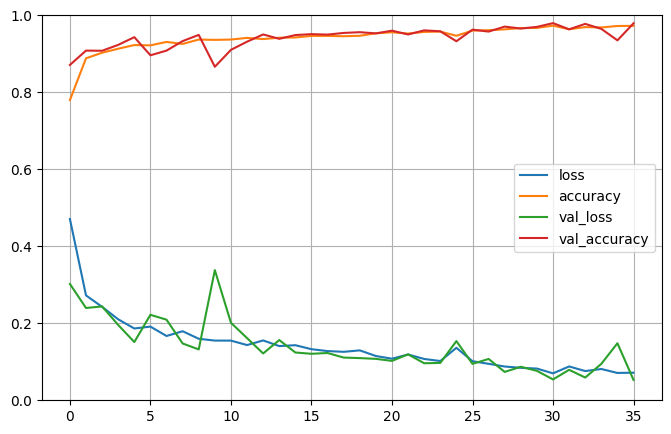

Train Loss : 7.16 %
Train Accuracy : 97.25 %
Validation Loss : 5.28 %
Validation Accuracy : 97.92 %
Test Classification Report
Test Loss :  5.3 %
Test Accuracy :  98.09 %


In [55]:
# 1st Model Train - Validation Report
TrValRepG(history_seq)
TrTeRep(Seq_Mod, test_ds)

Statement :<br>
The model showing a good fit train - validation with minimum explotions yet no gradient vanishing. The gaps between train, validation, and test sets is less than 1% and still have accuracy over than 97%.

In [15]:
# Predict the test set
y_test_pred = pd.DataFrame(Seq_Mod.predict(test_ds))

# Obtain the predict label based on the column name with highest probability
y_test_pred['Predict Label'] = y_test_pred.idxmax(axis=1)
y_test_pred.head()

36/36 [==============================] - 7s 194ms/step


0             1             2  Predict Label
0  1.837506e-02  4.439804e-05  9.815806e-01              2
1  3.470771e-03  4.311205e-09  9.965293e-01              2
2  4.173983e-12  1.000000e+00  4.347608e-18              1
3  9.999760e-01  2.151302e-09  2.397414e-05              0
4  9.985284e-01  1.135571e-04  1.358055e-03              0

In [16]:
# Turn the predicted label class into label into label

img_label = list(train_ds.class_indices.keys()) # Obtain labels from dictionary keys

for i in range(0, len(y_test_pred)):
    y_test_pred['Predict Label'][i] = img_label[y_test_pred.at[i, 'Predict Label']]

y_test_pred.head()

0             1             2 Predict Label
0  1.837506e-02  4.439804e-05  9.815806e-01      lung_scc
1  3.470771e-03  4.311205e-09  9.965293e-01      lung_scc
2  4.173983e-12  1.000000e+00  4.347608e-18        lung_n
3  9.999760e-01  2.151302e-09  2.397414e-05      lung_aca
4  9.985284e-01  1.135571e-04  1.358055e-03      lung_aca

In [17]:
# Combining predicted labels with actual labels
test_pred = pd.merge(test_set.reset_index( inplace = False, drop = True ), y_test_pred['Predict Label'], left_index = True, right_index = True)
test_pred.columns = ['Direct', 'Label', 'Predicted Label']
test_pred.head()

Direct     Label Predicted Label
0  ..\LungCancerClassifier\lung_colon_image_set\l...  lung_scc        lung_scc
1  ..\LungCancerClassifier\lung_colon_image_set\l...  lung_scc        lung_scc
2  ..\LungCancerClassifier\lung_colon_image_set\l...    lung_n          lung_n
3  ..\LungCancerClassifier\lung_colon_image_set\l...  lung_aca        lung_aca
4  ..\LungCancerClassifier\lung_colon_image_set\l...  lung_aca        lung_aca

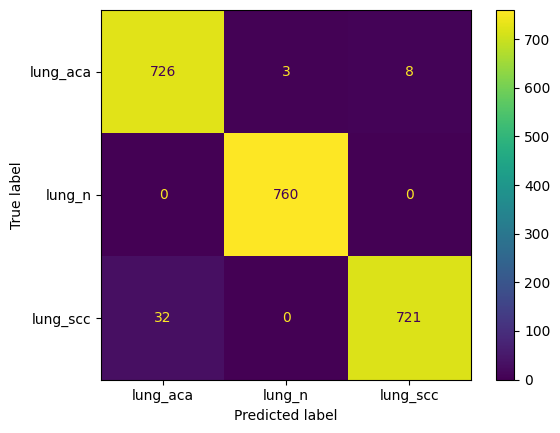

In [18]:
# Confusion matrix
ConMat = confusion_matrix(y_true = test_pred['Label'], y_pred = test_pred['Predicted Label'])
ConMatDisp = ConfusionMatrixDisplay(confusion_matrix = ConMat, display_labels = img_label)
ConMatDisp.plot()

In [19]:
# Making dataframe with wrong predicted labels only
false_pred = test_pred[test_pred['Label'] != test_pred['Predicted Label']]
false_pred.head()

Direct     Label  \
6    ..\LungCancerClassifier\lung_colon_image_set\l...  lung_scc   
52   ..\LungCancerClassifier\lung_colon_image_set\l...  lung_scc   
187  ..\LungCancerClassifier\lung_colon_image_set\l...  lung_scc   
275  ..\LungCancerClassifier\lung_colon_image_set\l...  lung_scc   
295  ..\LungCancerClassifier\lung_colon_image_set\l...  lung_scc   

    Predicted Label  
6          lung_aca  
52         lung_aca  
187        lung_aca  
275        lung_aca  
295        lung_aca

In [20]:
# Brief check
false_pred['Predicted Label'].value_counts()

lung_aca    32
lung_scc     8
lung_n       3
Name: Predicted Label, dtype: int64

Statement :<br>
Among all the labels, lung_aca is the least label the model can recognize.

In [36]:
# Make dataframe for each wrongly predicted labels
false_aca = false_pred[false_pred['Predicted Label'] == 'lung_aca'][['Direct']].reset_index(inplace = False, drop = True)
false_scc = false_pred[false_pred['Predicted Label'] == 'lung_scc'][['Direct']].reset_index(inplace = False, drop = True)
false_n = false_pred[false_pred['Predicted Label'] == 'lung_n'][['Direct']].reset_index(inplace = False, drop = True)

Lung Adenocarcinoma
Red samples   : 30.31 %
Green samples : 24.24 %
Blue samples  : 45.45 %


Lung Benign Tissue
Red samples   : 32.2 %
Green samples : 24.9 %
Blue samples  : 42.9 %


Lung Squamous Cell Carcinoma
Red samples   : 31.16 %
Green samples : 26.76 %
Blue samples  : 42.08 %


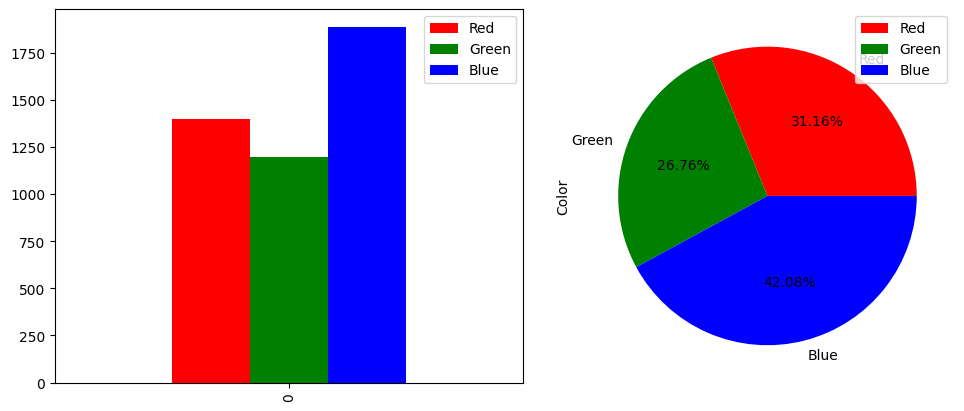

In [51]:
# Count RGB for each cancer class and plot colour composition

# Lung Adenocarcinoma
print('Lung Adenocarcinoma')

aca_R, aca_G, aca_B = RGB_counter_2(false_aca['Direct'])
print('Red samples   :', round(aca_R/(aca_R + aca_G + aca_B) * 100, 2), '%')
print('Green samples :', round(aca_G/(aca_R + aca_G + aca_B) * 100, 2), '%')
print('Blue samples  :', round(aca_B/(aca_R + aca_G + aca_B) * 100, 2), '%')

aca_wrong_RGB_sum_df_01 = pd.DataFrame({'Red': [aca_R], 'Green': [aca_G], 'Blue': [aca_B]})
aca_wrong_RGB_sum_df_02 = pd.DataFrame({'Color': [aca_R, aca_G, aca_B]}, index = ['Red', 'Green', 'Blue'])

fig, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
aca_wrong_RGB_sum_df_01.plot.bar(color={'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[0])
aca_wrong_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[1])
plt.show()

# Lung Benign Tissue
print('Lung Benign Tissue')

n_R, n_G, n_B = RGB_counter_2(false_n['Direct'])
print('Red samples   :', round(n_R/(n_R + n_G + n_B) * 100, 2), '%')
print('Green samples :', round(n_G/(n_R + n_G + n_B) * 100, 2), '%')
print('Blue samples  :', round(n_B/(n_R + n_G + n_B) * 100, 2), '%')

n_wrong_RGB_sum_df_01 = pd.DataFrame({'Red': [n_R], 'Green': [n_G], 'Blue': [n_B]})
n_wrong_RGB_sum_df_02 = pd.DataFrame({'Color': [n_R, n_G, n_B]}, index = ['Red', 'Green', 'Blue'])

fig, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
n_wrong_RGB_sum_df_01.plot.bar(color={'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[0])
n_wrong_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[1])
plt.show()

# Lung Squamous Cell Carcinoma
print('Lung Squamous Cell Carcinoma')
scc_R, scc_G, scc_B = RGB_counter_2(false_scc['Direct'])
print('Red samples   :', round(scc_R/(scc_R + scc_G + scc_B) * 100, 2), '%')
print('Green samples :', round(scc_G/(scc_R + scc_G + scc_B) * 100, 2), '%')
print('Blue samples  :', round(scc_B/(scc_R + scc_G + scc_B) * 100, 2), '%')

scc_wrong_RGB_sum_df_01 = pd.DataFrame({'Red': [scc_R], 'Green': [scc_G], 'Blue': [scc_B]})
scc_wrong_RGB_sum_df_02 = pd.DataFrame({'Color': [scc_R, scc_G, scc_B]}, index = ['Red', 'Green', 'Blue'])

fig, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
scc_wrong_RGB_sum_df_01.plot.bar(color={'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[0])
scc_wrong_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[1])
plt.show()

In [62]:
# Compare the wrongly predicted label color composition with the random sample dataset color composition

# Lung Adenocarcinoma
print('Lung Adenocarcinoma')
fig, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
aca_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[0])
aca_wrong_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[1])
plt.show()

# Lung Benign Tissue
print('Lung Benign Tissue')
fig, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
n_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[0])
n_wrong_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[1])
plt.show()

# Lung Squamous Cell Carcinoma
print('Lung Squamous Cell Carcinoma')
fig, axes = plt.subplots(1, 2, layout='constrained', figsize=(10,4))
scc_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[0])
scc_wrong_RGB_sum_df_02.plot.pie(y = 'Color', autopct = '%.2f%%', colors = {'Red':'red', 'Green':'green', 'Blue':'blue'}, ax = axes[1])
plt.show()

Lung Adenocarcinoma


Lung Benign Tissue


Lung Squamous Cell Carcinoma


Statement :<br>
Adenocarcinoma, which is the label with most number of wrong predictions, actually has a composition that is closest to the random sample color composition compared to other labels.<br>
Benign Tissue and Squamous Cell Carcinoma have a difference in color composition of about 1 - 6%, while difference in Adenocarcinoma  color composition only 0.14 - 0.92%.

Lung Adenocarcinoma


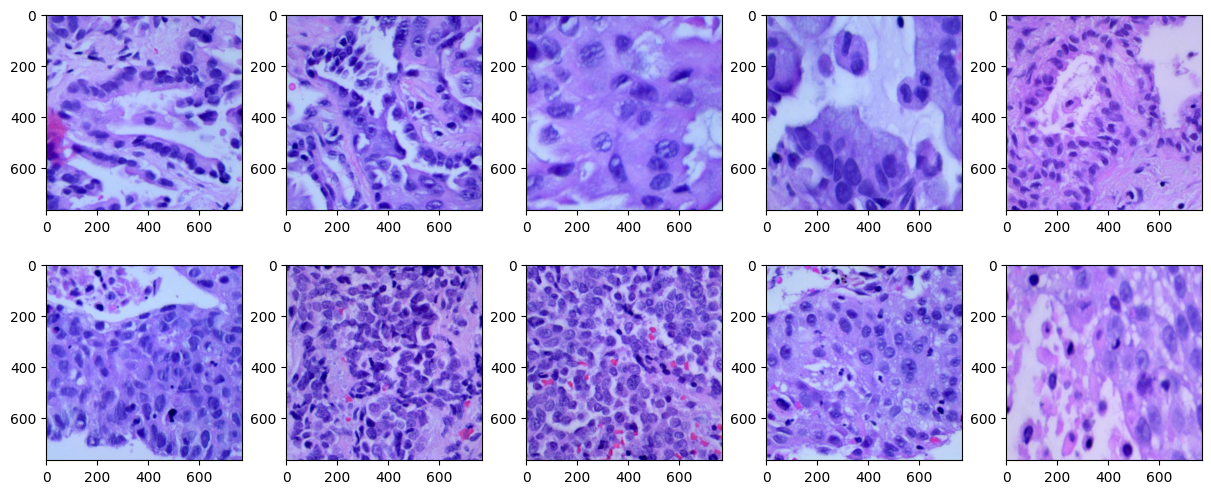

In [82]:
# Wrong predicted picture sampling for personal judgement

# Lung Adenocarcinoma
print('Lung Adenocarcinoma')
fig, axs = plt.subplots(2,5, layout="constrained", figsize=(12,5))
for i in range(0,5):
    axs[0,i].imshow(Image.open(lung_direct + lung_aca_RNG_dir[i]))
    axs[1,i].imshow(Image.open(false_aca['Direct'][i]))

Lung Benign Tissue


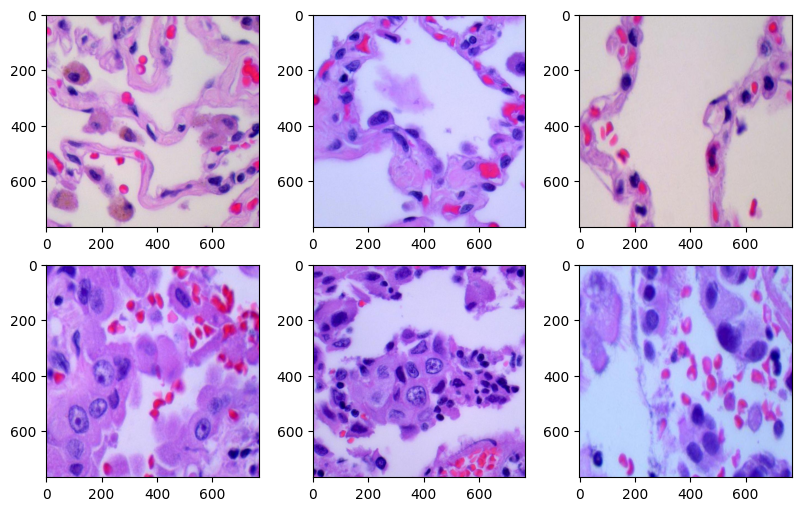

In [78]:
# Lung Benign Tissue
print('Lung Benign Tissue')
fig, axs = plt.subplots(2,3, layout="constrained", figsize=(8,5))
for i in range(0,3):
    axs[0,i].imshow(Image.open(lung_direct + lung_n_RNG_dir[i]))
    axs[1,i].imshow(Image.open(false_n['Direct'][i]))

Lung Squamous Cell Carcinoma


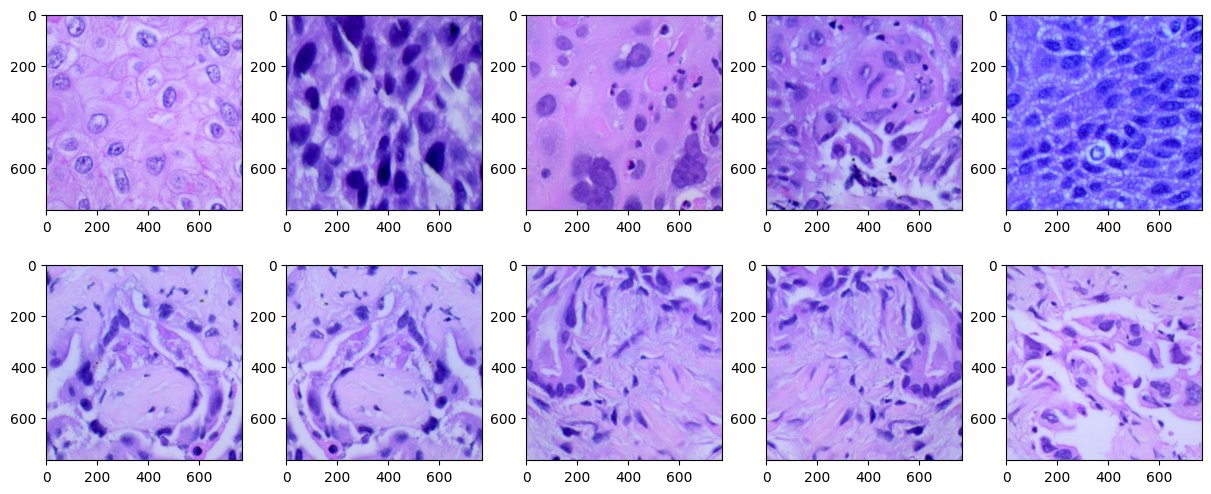

In [81]:
# Lung Squamous Cell Carcinoma
print('Lung Squamous Cell Carcinoma')
fig, axs = plt.subplots(2,5, layout="constrained", figsize=(12,5))
for i in range(0,5):
    axs[0,i].imshow(Image.open(lung_direct + lung_scc_RNG_dir[i]))
    axs[1,i].imshow(Image.open(false_scc['Direct'][i]))

Statement:<br>
Top = Actual pictures from sampling<br>
Bottom = Wrongly predicted pictures<br>
Using picture to picture comparison, I also unable tell the difference or find a marked difference between a wrongly labeled image and a sampled image. If they have different shades or patterns, adding the number of filters on the convolutional laters will greatly improve the model performance since the model will able to learn patterns even more. If they have different color composition, manipulate the color ( such as changging the color tone in order to make sure they have the same color temperature ) will help the model performance also.<br>
Since I can't even tell the difference, therefore I conclude that more datasets and more convolutional laters are needed in order to process the overall color and pattern deeper.

### 8. Model Saving

In [58]:
# Save the model
Seq_Mod.trainable = False # Freeze the model
Seq_Mod.save('PredictModel')

INFO:tensorflow:Assets written to: PredictModel\assets


INFO:tensorflow:Assets written to: PredictModel\assets


In [8]:
# Load the model
Seq_Mod = tf.keras.models.load_model('PredictModel')

### 9. Model Inference

1/1 [==============================] - 0s 19ms/step
Inference Image
Actual label :  lung_aca
Predict label : lung_aca - 57.56 %


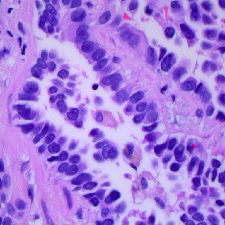

In [89]:
# Pick random picture as inference data
pict_inf = pd.DataFrame(df.sample(1)).reset_index(drop = True ,inplace = False)
inf_dir = pict_inf.at[0,'data']
inf_label = pict_inf.at[0,'label']

# Load image
img_inf = tf.keras.preprocessing.image.load_img(inf_dir, target_size = (225,225))

# Predict label
img_array = tf.keras.preprocessing.image.img_to_array(img_inf)
img_array = tf.expand_dims(img_array, 0)/225 # Color scaling
img_label = list(train_ds.class_indices.keys())

predictions = Seq_Mod.predict(img_array)
score = tf.nn.softmax(predictions[0])

print('Inference Image')
print('Actual label : ', inf_label)
if np.max(score) > 0.5:
    print('Predict label :', img_label[np.argmax(score)], '-', round(np.max(score) * 100, 2), '%')
else:
    print('Not cancer cells')
img_inf

### 10. Conclusions
1. This model is using around 10.000 images for training with total 3 classes of image. Thus, it is around 3300 images per class.
2. The model was using Sequential Model with 2 conversion layers only. If the available resources were large enough, Transform Learning using a deeper learning such as ResNet50 will surely improve the model performance since model with more layers and neurons perform a better report yet no sign of overfitting yet.
3. The model was performed very well with goodfit indicator based on its train - test accuracy percentage and gap.
4. Among all the labels, lung_aca is the least label the model can recognize. Therefore, lung_n and lung_scc are the most suitable data for the model.
5. Adding more datasets and convolutional layers so the model will process the overall color and pattern deeper.